# Load Data

In [1]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import notebook
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle

In [2]:
from tensorflow.keras.datasets import fashion_mnist

In [3]:
(x_train,_),(x_val,_) = fashion_mnist.load_data()

In [4]:
data = np.vstack([x_train, x_val])

In [5]:
data = (data.astype('float32') - 127.5) / 127.5

In [6]:
data = data.reshape(-1,784)

In [7]:
adam = Adam(learning_rate= 0.0002, beta_1= 0.5)

# Build model

In [8]:
from tensorflow.keras.layers import * 
from tensorflow.keras.models import Model, Sequential

In [9]:
def generator(dim_noise = 100):
    input = Input(dim_noise)
    x = Dense(7 * 7 * 256)(input)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Reshape((7,7,256))(x)
    
    x = Conv2DTranspose(128, kernel_size= (3,3), strides= 2, padding= 'same')(x) # 14
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2DTranspose(64, kernel_size= (4,4), strides= 2, padding= 'same')(x) # 28
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(1, kernel_size= (4,4), strides= 1, padding= 'same', activation= 'tanh')(x)
    x = Flatten()(x)
    return Model(input, x, name = 'generator_model')

def discriminator():
    input = Input(shape = (28 * 28))
    x = Reshape((28,28,1))(input)
    x = Conv2D(128, kernel_size = (5,5), strides = 2, padding = 'same')(x) # 14
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(256, kernel_size = (5,5), strides = 2, padding = 'same')(x) # 14
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
     
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(1, activation = 'sigmoid')(x)
    return Model(input, x, name = 'discriminator')
g = generator()
d = discriminator()


In [10]:
def show_example():
    noise = np.random.normal(size = (10,100))
    image_generate = g(noise).numpy().reshape(-1,28,28)
    plt.figure(figsize= (12,2))
    for i in range(10):
        plt.subplot(1,10,i + 1)
        plt.imshow(image_generate[i], interpolation='nearest', cmap='gray_r' )
        plt.axis('off')
    plt.show()

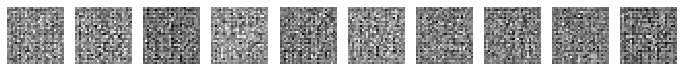

In [11]:
# test code
show_example()

# Loss 

In [12]:
mse = tf.losses.MeanSquaredError()

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = mse(tf.ones_like(real_output), real_output)
    fake_loss = mse(tf.zeros_like(fake_output), fake_output)
    total_loss =  real_loss + fake_loss
    return total_loss

In [14]:
def generator_loss(fake_output):
    fake_loss = mse(tf.ones_like(fake_output), fake_output)
    return fake_loss

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0002, beta_1= 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate= 0.00015, beta_1= 0.5)

In [16]:

def train_step(images):
    noise = tf.random.normal([images.shape[0], 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = g(noise, training = True)
    
        real_output = d(images, training = True)
        fake_output = d(generated_images, training = True)
    
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(real_output, fake_output)
    
    gradient_of_gen = gen_tape.gradient(gen_loss, g.trainable_variables)
    gradient_of_disc = disc_tape.gradient(dis_loss, d.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradient_of_gen, g.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradient_of_disc, d.trainable_variables))
    return gen_loss, dis_loss
    

# Train

In [17]:
Loss_g, Loss_d = [], []
def train(image, batch_size = 256, epochs = 50, verbose = 1):
    interation = int(len(image) / batch_size)
    for i in range(1, epochs + 1):
        if i % verbose == 0:
            print(f'Epochs {i}: ', end= '')
        indexes = np.arange(len(image))
        indexes = shuffle(indexes)
        fake_acc, real_acc = [], []
        loss_D, loss_G = [], []
        for j in notebook.tqdm(range(interation)):
            index = indexes[j * batch_size : (j + 1) * batch_size]
            real_img = np.array([image[k] for k in index])
            loss_g, loss_d = train_step(real_img)
            loss_G.append(loss_g)
            loss_D.append(loss_d)

        if i % verbose == 0:
            show_example()
            print('d_loss: %f   g_loss: %f' % (np.array(loss_D).mean(), np.array(loss_G).mean()))
            Loss_d.append(np.array(loss_D).mean())
            Loss_g.append(np.array(loss_G).mean())

Epochs 1: 

  0%|          | 0/273 [00:00<?, ?it/s]

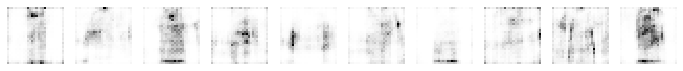

d_loss: 0.218706   g_loss: 0.626979
Epochs 2: 

  0%|          | 0/273 [00:00<?, ?it/s]

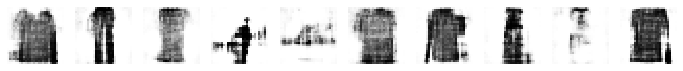

d_loss: 0.164015   g_loss: 0.657501
Epochs 3: 

  0%|          | 0/273 [00:00<?, ?it/s]

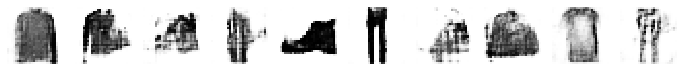

d_loss: 0.260165   g_loss: 0.554263
Epochs 4: 

  0%|          | 0/273 [00:00<?, ?it/s]

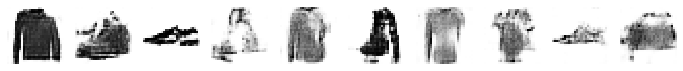

d_loss: 0.318551   g_loss: 0.495019
Epochs 5: 

  0%|          | 0/273 [00:00<?, ?it/s]

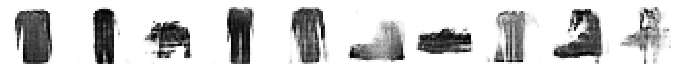

d_loss: 0.351132   g_loss: 0.466243
Epochs 6: 

  0%|          | 0/273 [00:00<?, ?it/s]

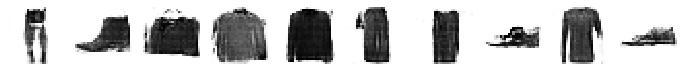

d_loss: 0.362220   g_loss: 0.458269
Epochs 7: 

  0%|          | 0/273 [00:00<?, ?it/s]

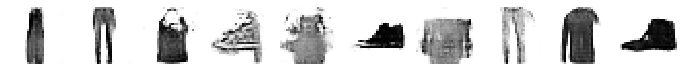

d_loss: 0.363944   g_loss: 0.452539
Epochs 8: 

  0%|          | 0/273 [00:00<?, ?it/s]

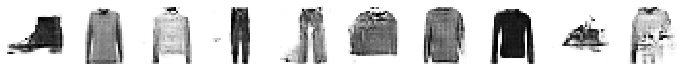

d_loss: 0.372553   g_loss: 0.444659
Epochs 9: 

  0%|          | 0/273 [00:00<?, ?it/s]

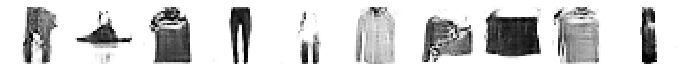

d_loss: 0.377924   g_loss: 0.440034
Epochs 10: 

  0%|          | 0/273 [00:00<?, ?it/s]

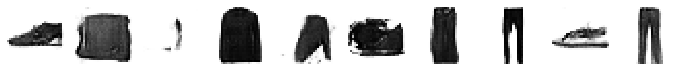

d_loss: 0.377850   g_loss: 0.436112
Epochs 11: 

  0%|          | 0/273 [00:00<?, ?it/s]

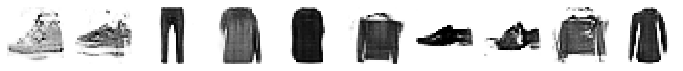

d_loss: 0.378451   g_loss: 0.435756
Epochs 12: 

  0%|          | 0/273 [00:00<?, ?it/s]

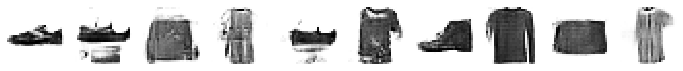

d_loss: 0.380374   g_loss: 0.434487
Epochs 13: 

  0%|          | 0/273 [00:00<?, ?it/s]

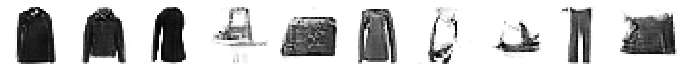

d_loss: 0.382377   g_loss: 0.433468
Epochs 14: 

  0%|          | 0/273 [00:00<?, ?it/s]

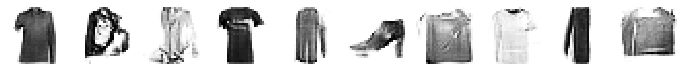

d_loss: 0.384432   g_loss: 0.430178
Epochs 15: 

  0%|          | 0/273 [00:00<?, ?it/s]

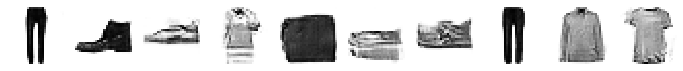

d_loss: 0.384932   g_loss: 0.428414
Epochs 16: 

  0%|          | 0/273 [00:00<?, ?it/s]

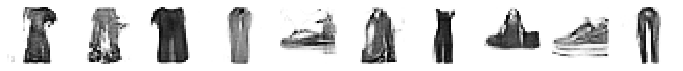

d_loss: 0.392909   g_loss: 0.425235
Epochs 17: 

  0%|          | 0/273 [00:00<?, ?it/s]

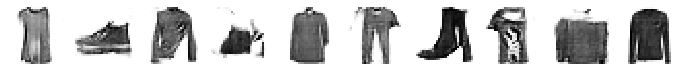

d_loss: 0.387891   g_loss: 0.423217
Epochs 18: 

  0%|          | 0/273 [00:00<?, ?it/s]

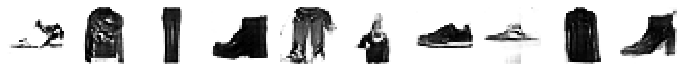

d_loss: 0.390943   g_loss: 0.423025
Epochs 19: 

  0%|          | 0/273 [00:00<?, ?it/s]

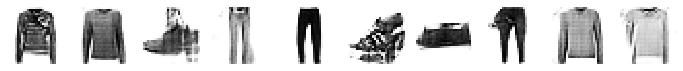

d_loss: 0.393513   g_loss: 0.420776
Epochs 20: 

  0%|          | 0/273 [00:00<?, ?it/s]

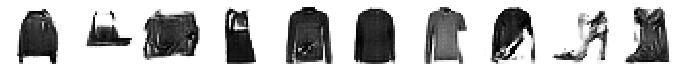

d_loss: 0.394275   g_loss: 0.419525
Epochs 21: 

  0%|          | 0/273 [00:00<?, ?it/s]

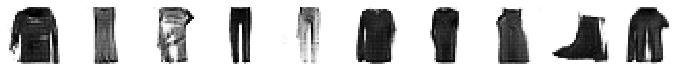

d_loss: 0.392639   g_loss: 0.420181
Epochs 22: 

  0%|          | 0/273 [00:00<?, ?it/s]

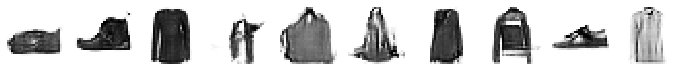

d_loss: 0.392659   g_loss: 0.419654
Epochs 23: 

  0%|          | 0/273 [00:00<?, ?it/s]

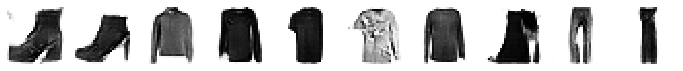

d_loss: 0.393434   g_loss: 0.421920
Epochs 24: 

  0%|          | 0/273 [00:00<?, ?it/s]

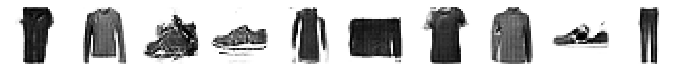

d_loss: 0.391780   g_loss: 0.420506
Epochs 25: 

  0%|          | 0/273 [00:00<?, ?it/s]

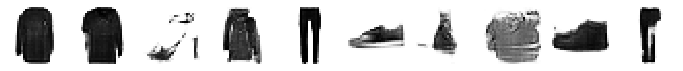

d_loss: 0.393605   g_loss: 0.418299
Epochs 26: 

  0%|          | 0/273 [00:00<?, ?it/s]

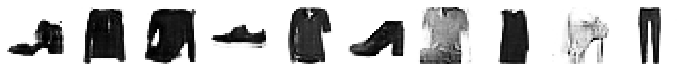

d_loss: 0.391978   g_loss: 0.418693
Epochs 27: 

  0%|          | 0/273 [00:00<?, ?it/s]

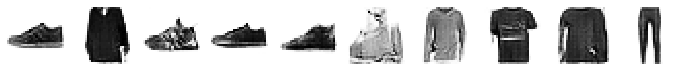

d_loss: 0.392735   g_loss: 0.419385
Epochs 28: 

  0%|          | 0/273 [00:00<?, ?it/s]

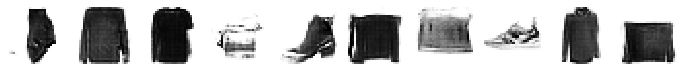

d_loss: 0.390661   g_loss: 0.421162
Epochs 29: 

  0%|          | 0/273 [00:00<?, ?it/s]

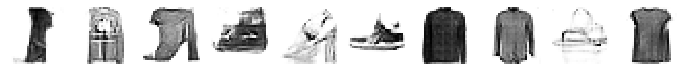

d_loss: 0.392917   g_loss: 0.420506
Epochs 30: 

  0%|          | 0/273 [00:00<?, ?it/s]

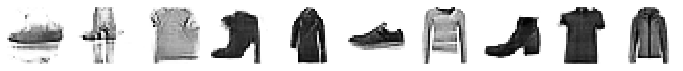

d_loss: 0.390143   g_loss: 0.419997
Epochs 31: 

  0%|          | 0/273 [00:00<?, ?it/s]

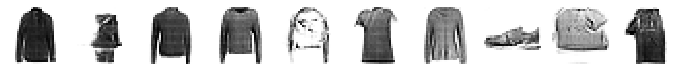

d_loss: 0.388362   g_loss: 0.421784
Epochs 32: 

  0%|          | 0/273 [00:00<?, ?it/s]

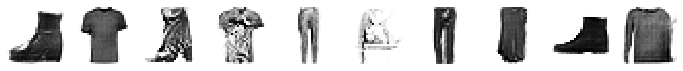

d_loss: 0.388988   g_loss: 0.422435
Epochs 33: 

  0%|          | 0/273 [00:00<?, ?it/s]

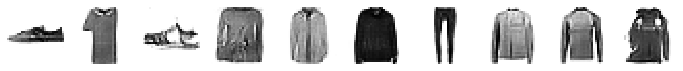

d_loss: 0.388744   g_loss: 0.422649
Epochs 34: 

  0%|          | 0/273 [00:00<?, ?it/s]

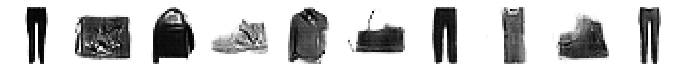

d_loss: 0.388724   g_loss: 0.422030
Epochs 35: 

  0%|          | 0/273 [00:00<?, ?it/s]

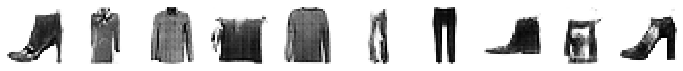

d_loss: 0.386988   g_loss: 0.423692
Epochs 36: 

  0%|          | 0/273 [00:00<?, ?it/s]

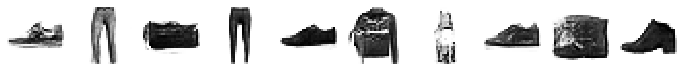

d_loss: 0.387746   g_loss: 0.422492
Epochs 37: 

  0%|          | 0/273 [00:00<?, ?it/s]

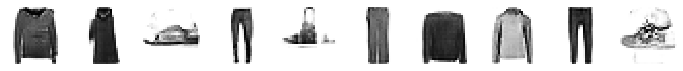

d_loss: 0.385660   g_loss: 0.425617
Epochs 38: 

  0%|          | 0/273 [00:00<?, ?it/s]

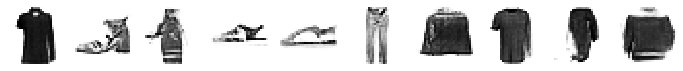

d_loss: 0.384736   g_loss: 0.426757
Epochs 39: 

  0%|          | 0/273 [00:00<?, ?it/s]

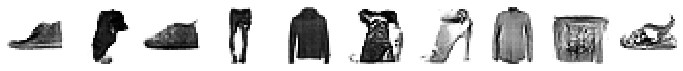

d_loss: 0.387678   g_loss: 0.424741
Epochs 40: 

  0%|          | 0/273 [00:00<?, ?it/s]

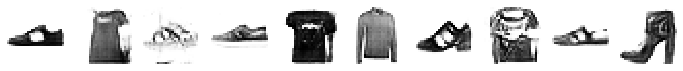

d_loss: 0.385405   g_loss: 0.425497
Epochs 41: 

  0%|          | 0/273 [00:00<?, ?it/s]

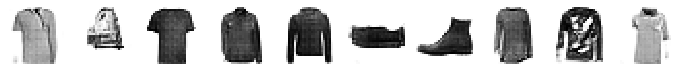

d_loss: 0.381851   g_loss: 0.428217
Epochs 42: 

  0%|          | 0/273 [00:00<?, ?it/s]

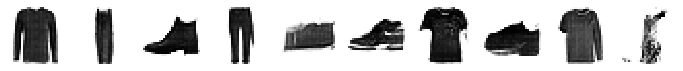

d_loss: 0.384080   g_loss: 0.427649
Epochs 43: 

  0%|          | 0/273 [00:00<?, ?it/s]

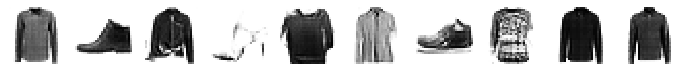

d_loss: 0.384731   g_loss: 0.427964
Epochs 44: 

  0%|          | 0/273 [00:00<?, ?it/s]

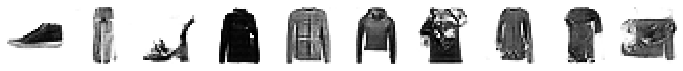

d_loss: 0.382812   g_loss: 0.427817
Epochs 45: 

  0%|          | 0/273 [00:00<?, ?it/s]

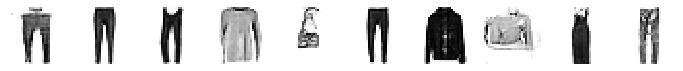

d_loss: 0.385070   g_loss: 0.426945
Epochs 46: 

  0%|          | 0/273 [00:00<?, ?it/s]

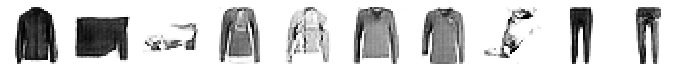

d_loss: 0.382735   g_loss: 0.427373
Epochs 47: 

  0%|          | 0/273 [00:00<?, ?it/s]

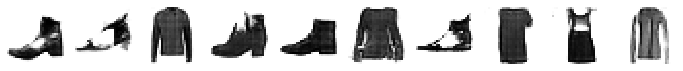

d_loss: 0.384928   g_loss: 0.430333
Epochs 48: 

  0%|          | 0/273 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [18]:
train(data)

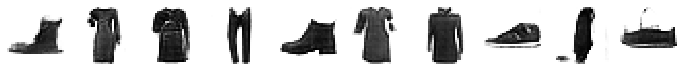

In [20]:
show_example()